# Обнаружение объектов на изображениях продуктов питания с помощью PyTorch  
## Обучающий компьютерный блокнот по зрению

**Задача:** Обнаружение объектов  
**Фреймворк:** PyTorch  
**Модель:** Faster R-CNN (ResNet-50 FPN)  
**Набор данных:** MM-Food-100K  

В этом блокноте демонстрируется полный цикл обучения модели обнаружения объектов:
- загрузка и предварительная обработка набора данных,
- инициализация модели,
- процесс обучения,
- визуализация результатов *до и после обучения*.


## 1. Imports and Environment Setup


In [42]:

!pip install requests
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os


## 2. Загрузка датасета

Мы используем датасет данных MM-Food-100K из HuggingFace.
В образовательных целях мы будем работать с небольшим подмножеством изображений.

In [43]:

df = pd.read_csv("hf://datasets/Codatta/MM-Food-100K/MM-Food-100K.csv")
df.head()


'The read operation timed out' thrown while requesting GET https://huggingface.co/datasets/Codatta/MM-Food-100K/resolve/main/MM-Food-100K.csv
Retrying in 1s [Retry 1/5].


,image_url,camera_or_phone_prob,food_prob,dish_name,food_type,ingredients,portion_size,nutritional_profile,cooking_method,sub_dt
0,https://file.b18a.io/7843322356500104680_44354...,0.7,0.95,Fried Chicken,Restaurant food,"[""chicken"",""breading"",""oil""]","[""chicken:300g""]","{""fat_g"":25.0,""protein_g"":30.0,""calories_kcal""...",Frying,20250704
1,https://file.b18a.io/7833227147700100732_67487...,0.7,1.00,Pho,Restaurant food,"[""noodles"",""beef"",""basil"",""lime"",""green onions...","[""noodles:200g"",""beef:100g"",""vegetables:50g""]","{""fat_g"":15.0,""protein_g"":25.0,""calories_kcal""...",boiled,20250702
2,https://file.b18a.io/7832600581600103585_26423...,0.8,0.95,Pan-fried Dumplings,Restaurant food,"[""dumplings"",""chili oil"",""soy sauce""]","[""dumplings:300g"",""sauce:50g""]","{""fat_g"":15.0,""protein_g"":20.0,""calories_kcal""...",Pan-frying,20250625
3,https://file.b18a.io/7839056601700101188_98515...,0.7,1.00,Bananas,Raw vegetables and fruits,"[""Bananas""]","[""Bananas: 10 pieces (about 1kg)""]","{""fat_g"":3.0,""protein_g"":12.0,""calories_kcal"":...",Raw,20250718
4,https://file.b18a.io/7837642737500100261_17312...,0.8,0.90,Noodle Stir-Fry,Restaurant food,"[""noodles"",""chicken"",""vegetables"",""sauce""]","[""noodles:300g"",""chicken:100g"",""vegetables:50g""]","{""fat_g"":20.0,""protein_g"":25.0,""calories_kcal""...",stir-fried,20250711


In [44]:
import os
from pathlib import Path
import requests

# Сколько изображений использовать (совпадает с max_samples=200 в датасете)
NUM_IMAGES = 200

# Берём только первые NUM_IMAGES строк
df = df.head(NUM_IMAGES).reset_index(drop=True)

images_dir = Path("images")
images_dir.mkdir(exist_ok=True)

def download_and_get_path(row):
    url = row["image_url"]          # колонка из CSV
    filename = f"{row.name}.jpg"    # имя файла по индексу строки
    filepath = images_dir / filename

    if not filepath.exists():
        resp = requests.get(url, timeout=30)
        resp.raise_for_status()
        with open(filepath, "wb") as f:
            f.write(resp.content)

    return filename

df["image_path"] = df.apply(download_and_get_path, axis=1)

df[["image_url", "image_path"]].head()

,image_url,image_path
0,https://file.b18a.io/7843322356500104680_44354...,0.jpg
1,https://file.b18a.io/7833227147700100732_67487...,1.jpg
2,https://file.b18a.io/7832600581600103585_26423...,2.jpg
3,https://file.b18a.io/7839056601700101188_98515...,3.jpg
4,https://file.b18a.io/7837642737500100261_17312...,4.jpg


## 3. Пользовательский набор данных PyTorch

Для упрощенного примера мы предполагаем, что:
- один пищевой объект на изображении,
- ограничивающая рамка закрывает основной объект.

In [45]:

class FoodDetectionDataset(Dataset):
    def __init__(self, dataframe, image_root, transforms=None, max_samples=200):
        self.df = dataframe.head(max_samples)
        self.image_root = image_root
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_root, row['image_path'])
        image = Image.open(img_path).convert("RGB")

        width, height = image.size
        boxes = torch.tensor([[0, 0, width, height]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


## 4. Загрузчик данных

In [46]:

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = FoodDetectionDataset(df, image_root="images", transforms=F.to_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


## 5. Инициализация модели

Мы используем **предварительно обученный более быстрый R-CNN** и адаптируем его к одному классу (продукты питания).

In [47]:

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # background + food

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


C:\Users\jorjanoo\Downloads\food-cv\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jorjanoo\Downloads\food-cv\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(


## 6. Исходный вывод (перед тренировкой)

In [48]:

model.eval()
images, targets = next(iter(dataloader))
images = [img.to(device) for img in images]

with torch.no_grad():
    outputs = model(images)

outputs[0]


{'boxes': tensor([[417.5987, 256.3560, 489.8004, 319.5548],
         [158.6261, 406.4341, 513.8471, 800.0000],
         [427.7225, 263.1997, 467.7928, 309.1298],
         [439.9238, 253.2338, 505.6400, 344.8091],
         [452.5123,  57.1303, 647.7537, 554.9492],
         [381.4586,  86.9667, 570.7526, 577.2869],
         [476.3188, 235.6958, 552.8050, 507.1594],
         [241.4973, 256.1801, 450.3989, 617.1013],
         [197.6163,  36.7202, 420.5409, 385.8873],
         [ 76.9311, 267.2486, 470.2201, 566.8268],
         [648.3844, 452.5318, 741.8357, 655.8922],
         [440.3232, 296.6804, 568.6834, 455.7545],
         [115.0820,  97.2908, 551.7474, 341.0550],
         [ 11.0824, 195.1351, 367.6028, 796.7947],
         [199.3791, 198.4161, 620.1530, 582.3796],
         [445.0149, 439.8474, 755.6365, 727.1696],
         [615.4769, 376.2538, 714.9832, 593.0897],
         [493.8381, 309.3030, 531.7769, 445.7434],
         [559.6232, 478.8560, 735.7668, 645.4807],
         [315.6949, 14


## 7. Подготовка к тренировке

In [49]:

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)



## 8. Тренировочный цикл

In [50]:
num_epochs = 10          # сколько эпох хотим всего
loss_history = []        # сюда будем складывать loss

# ===== Настройка пути к чекпоинту =====
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "fasterrcnn_food.pt")

# ===== Попытка возобновить обучение из чекпоинта =====
start_epoch = 0
if os.path.exists(ckpt_path):
    print(f"Найден чекпоинт: {ckpt_path}, загружаю...")
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    loss_history = checkpoint.get("loss_history", [])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Продолжаем с эпохи {start_epoch+1}/{num_epochs}")
else:
    print("Чекпоинт не найден, начинаем обучение с нуля.")

current_epoch = start_epoch

try:
    for epoch in range(start_epoch, num_epochs):
        current_epoch = epoch
        model.train()
        epoch_loss = 0.0

        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # ===== Сохраняем чекпоинт в конце КАЖДОЙ эпохи =====
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss_history": loss_history,
        }, ckpt_path)
        print(f"Чекпоинт сохранён: {ckpt_path}")

except KeyboardInterrupt:
    # ===== Сохранение при нажатии Stop  =====
    print("\nОбучение прервано пользователем. Сохраняю чекпоинт...")
    torch.save({
        "epoch": current_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss_history": loss_history,
    }, ckpt_path)
    print(f"Чекпоинт сохранён: {ckpt_path}")

Найден чекпоинт: checkpoints\fasterrcnn_food.pt, загружаю...
Продолжаем с эпохи 11/10



## 9. Визуализация хода тренировки

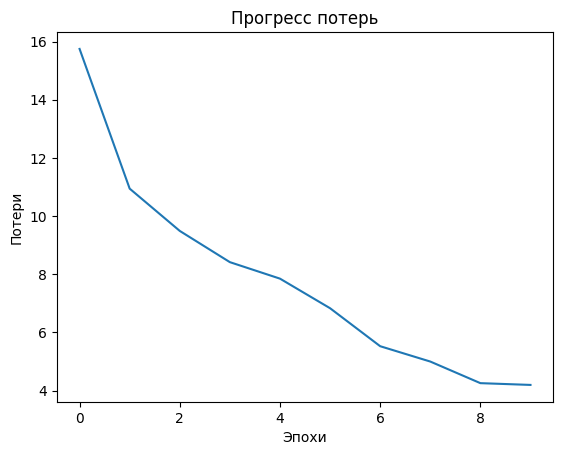

In [51]:

plt.plot(loss_history)
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.title("Прогресс потерь")
plt.show()


## 10. Выводы после обучения

In [52]:

model.eval()
with torch.no_grad():
    outputs_after = model(images)

outputs_after[0]


{'boxes': tensor([[  8.8887,  24.4555, 800.0000, 800.0000]]),
 'labels': tensor([1]),
 'scores': tensor([1.0000])}

## 11. Выводы

- Модель демонстрирует повышенную надежность после обучения.
- Более быстрый R-CNN подходит для задач обнаружения пищевых объектов.
- Дальнейшие улучшения включают в себя аннотации в виде реальных ограничивающих рамок и мультиклассовое обнаружение.